In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
def perform_fft_and_plot(wav_file:str):
    # Read the WAV file
    sample_rate, audio_data = wavfile.read(wav_file)
    
    # Ensure audio data is mono for simplicity
    if len(audio_data.shape) > 1:
        audio_data = audio_data[:, 0]  # Take the first channel
    
    # Perform FFT
    n = len(audio_data)
    fft_result = np.fft.fft(audio_data)
    fft_magnitude = np.abs(fft_result)[:n // 2]  # Take the magnitude and half the spectrum
    frequencies = np.fft.fftfreq(n, 1/sample_rate)[:n // 2]  # Frequencies corresponding to the FFT

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies, fft_magnitude)
    plt.title(f'FFT of {wav_file}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(0, sample_rate / 2)  # Plot up to Nyquist frequency
    plt.grid()
    plt.show()



In [4]:

PARENT_PATH = os.path.dirname(os.getcwd())
PREPROCESSED_DATA_PATH = os.path.join(PARENT_PATH, 'Data-Collected','Preprocessed-Data','Audio-Files','2024-9-19-6-44-38.wav')

In [5]:
RAW_DATA_PATH = os.path.join(PARENT_PATH, 'Data-Collected','Raw-Data','Sample-03','2024-11-2-11-4-38.txt')

In [5]:
sample_rate, audio_data = wavfile.read(PREPROCESSED_DATA_PATH)
print(f'Sample rate: {sample_rate} Hz')

Sample rate: 1000 Hz


1166
[ 514  896  -20 ... 1546 1112 1166]
RMS: 1206.6487752759706


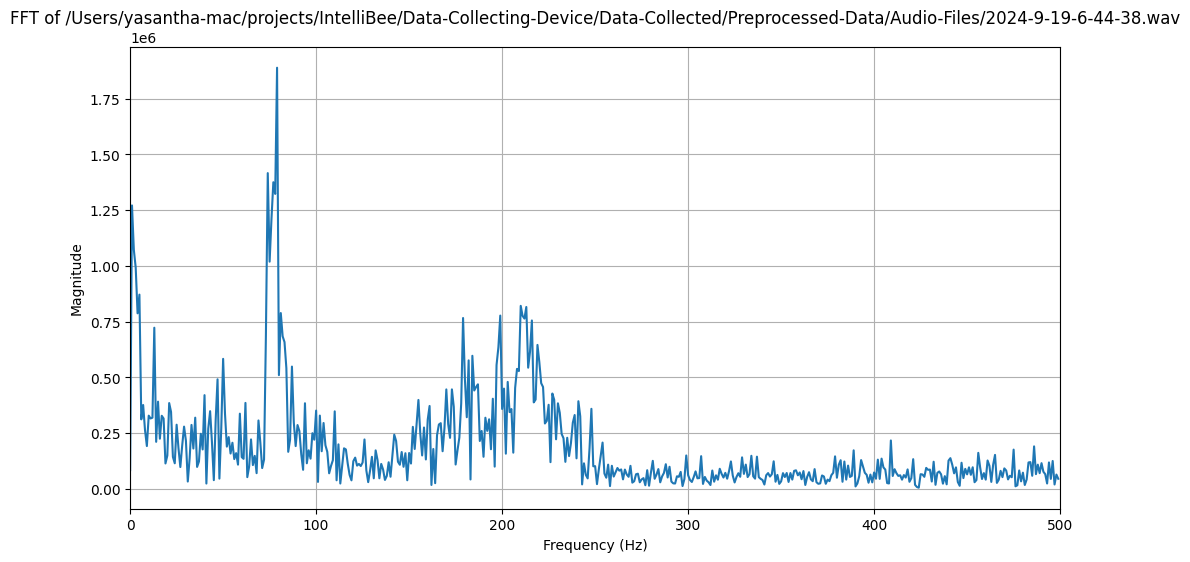

In [8]:
data:None
with open(RAW_DATA_PATH, 'r') as file:
    data = file.read()


data = data.split('\n')[1].strip(",").split(',')
data = data[:8000]
print(data[-1])
numpy_data = np.array(data, dtype=np.int32)
print(numpy_data)
rms = np.sqrt(np.mean(numpy_data**2))
print(f'RMS: {rms}')
fft_result = np.fft.fft(numpy_data)
sample_rate = 8000
fft_magnitude = np.abs(fft_result)[:len(numpy_data) // 16]  # Take the magnitude and half the spectrum
frequencies = np.fft.fftfreq(len(numpy_data), 1/sample_rate)[:len(numpy_data) // 16]  # Frequencies corresponding to the FFT
plt.figure(figsize=(12, 6))
plt.plot(frequencies, fft_magnitude)
plt.title(f'FFT of {PREPROCESSED_DATA_PATH}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, sample_rate / 16)  # Plot up to Nyquist frequency
plt.grid()
plt.show()

In [7]:
n = len(audio_data)
fft_result = np.fft.fft(audio_data)
fft_magnitude = np.abs(fft_result)[:n // 2]  # Take the magnitude and half the spectrum
frequencies = np.fft.fftfreq(n, 1/sample_rate)[:n // 2]  # Frequencies corresponding to the FFT


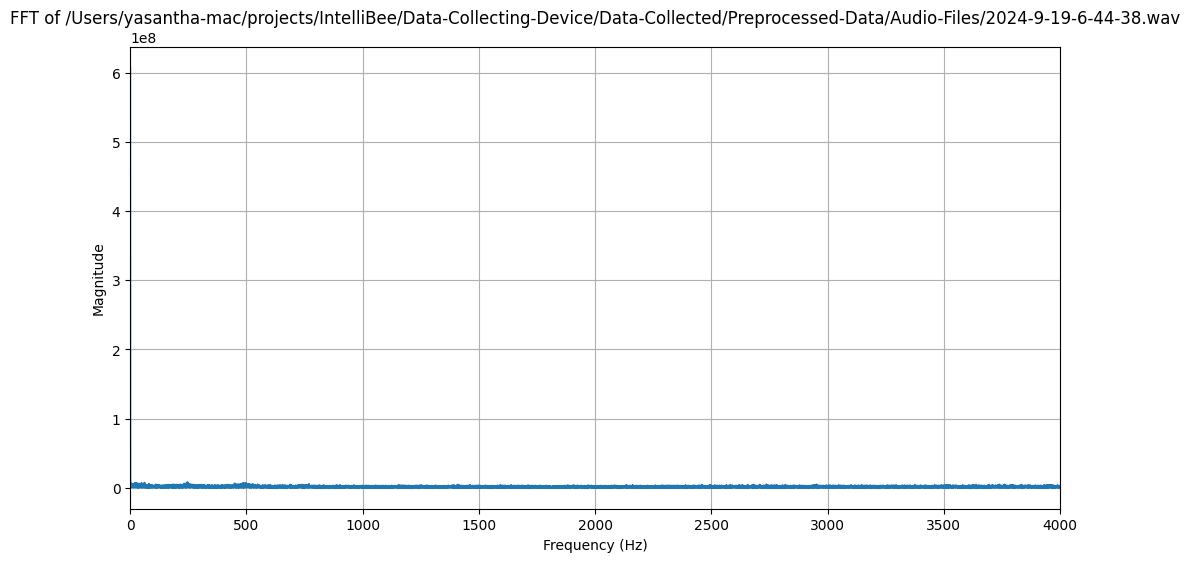

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(frequencies, fft_magnitude)
plt.title(f'FFT of {PREPROCESSED_DATA_PATH}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, sample_rate / 2)  # Plot up to Nyquist frequency
plt.grid()
plt.show()

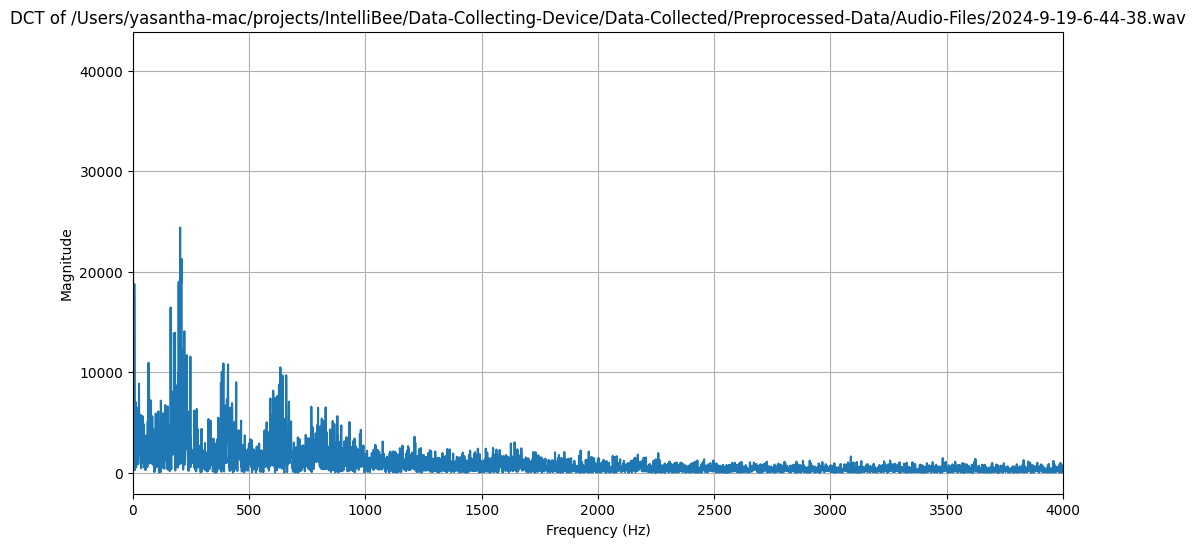

In [9]:
from scipy.fftpack import dct

# Perform DCT
dct_result = dct(numpy_data, norm='ortho')  # Use orthogonal normalization
# Take the magnitude for visualization
dct_magnitude = np.abs(dct_result)

# Create frequency array for plotting
sample_rate = 8000  # Define the sample rate
N = len(numpy_data)
frequencies = np.linspace(0, sample_rate / 2, num=N // 2)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:N//2], dct_magnitude[:N//2])  # Plot only the first half of the DCT result
plt.title(f'DCT of {PREPROCESSED_DATA_PATH}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, sample_rate / 2)  # Plot up to Nyquist frequency
plt.grid()
plt.show()

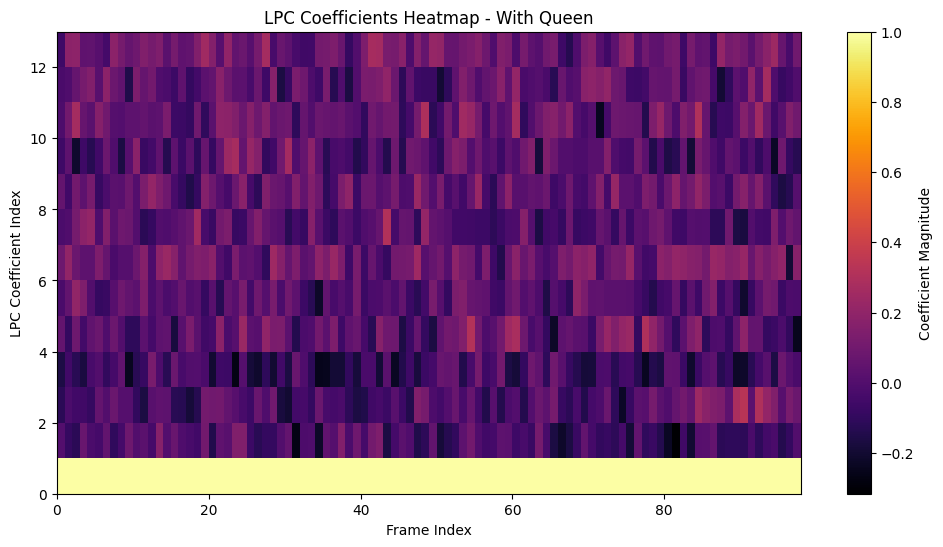

In [22]:
from scipy.signal import lfilter

from scipy.linalg import solve_toeplitz


def calculate_lpc_coefficients(signal, sampling_rate, lpc_order=12, frame_size_ms=25, frame_step_ms=10):
    # Preprocess the signal (pre-emphasis)
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    
    # Convert frame size and step size from milliseconds to samples
    frame_size = int(frame_size_ms * sampling_rate / 1000)
    frame_step = int(frame_step_ms * sampling_rate / 1000)
    signal_length = len(emphasized_signal)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_size)) / frame_step))

    # Pad signal so that all frames have equal length
    pad_signal_length = num_frames * frame_step + frame_size
    z = np.zeros((pad_signal_length - signal_length))
    padded_signal = np.append(emphasized_signal, z)

    # Split signal into frames
    indices = np.tile(np.arange(0, frame_size), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_size, 1)).T
    frames = padded_signal[indices.astype(np.int32, copy=False)]

    # Apply Hamming window to each frame
    frames *= np.hamming(frame_size)

    # Function to compute autocorrelation
    def autocorrelation(signal, order):
        result = np.correlate(signal, signal, mode='full')
        return result[len(result)//2:len(result)//2 + order + 1]

    # Function to compute LPC coefficients
    def lpc(signal, order):
        R = autocorrelation(signal, order)
        R_matrix = solve_toeplitz((R[:-1], R[:-1]), R[1:])
        return np.concatenate(([1], -R_matrix))

    # Calculate LPC coefficients for each frame
    lpc_coefficients = []
    for frame in frames:
        coeffs = lpc(frame, lpc_order)
        lpc_coefficients.append(coeffs)
    
    return np.array(lpc_coefficients)
# Calculate LPC coefficients
lpc_order = 12
lpc_coeffs = calculate_lpc_coefficients(numpy_data, sample_rate, lpc_order=lpc_order)


plt.figure(figsize=(12, 6))
plt.imshow(lpc_coeffs.T, aspect='auto', origin='lower', cmap='inferno', extent=[0, len(lpc_coeffs), 0, lpc_order + 1])
plt.title("LPC Coefficients Heatmap - With Queen")
plt.xlabel("Frame Index")
plt.ylabel("LPC Coefficient Index")
plt.colorbar(label="Coefficient Magnitude")
plt.show()

Zero Crossing Rate: 0.1181
Root Mean Square: 12.6529


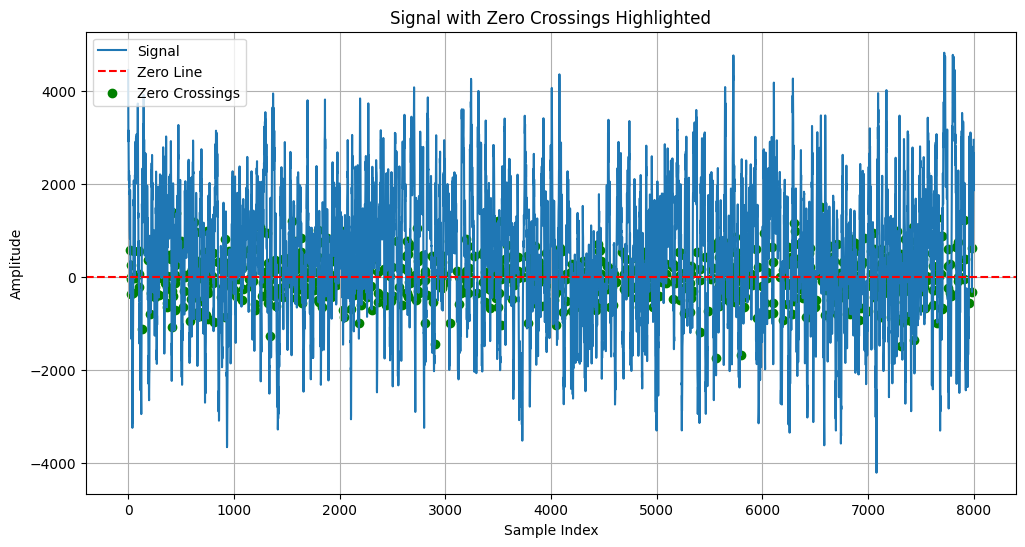

In [19]:
# Function to calculate Zero Crossing Rate
def zero_crossing_rate(signal):
    """Calculate the zero crossing rate of the signal."""
    sign_changes = np.diff(np.sign(signal))
    zcr = np.sum(sign_changes != 0) / len(signal)  # Count non-zero sign changes and normalize
    return zcr

# Function to calculate Root Mean Square (RMS)
def root_mean_square(signal):
    """Calculate the RMS of the signal."""
    rms = np.sqrt(np.mean(signal**2))
    return rms

# Calculate ZCR and RMS
zcr_value = zero_crossing_rate(numpy_data)
rms_value = root_mean_square(numpy_data)

# Print the results
print(f'Zero Crossing Rate: {zcr_value:.4f}')
print(f'Root Mean Square: {rms_value:.4f}')

# Optionally, plot the signal and highlight zero crossings
plt.figure(figsize=(12, 6))
plt.plot(numpy_data, label='Signal')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
zero_crossings = np.where(np.diff(np.sign(numpy_data)))[0]  # Find zero crossings
plt.scatter(zero_crossings, numpy_data[zero_crossings], color='green', label='Zero Crossings', marker='o')
plt.title('Signal with Zero Crossings Highlighted')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (13,) and (4000,)

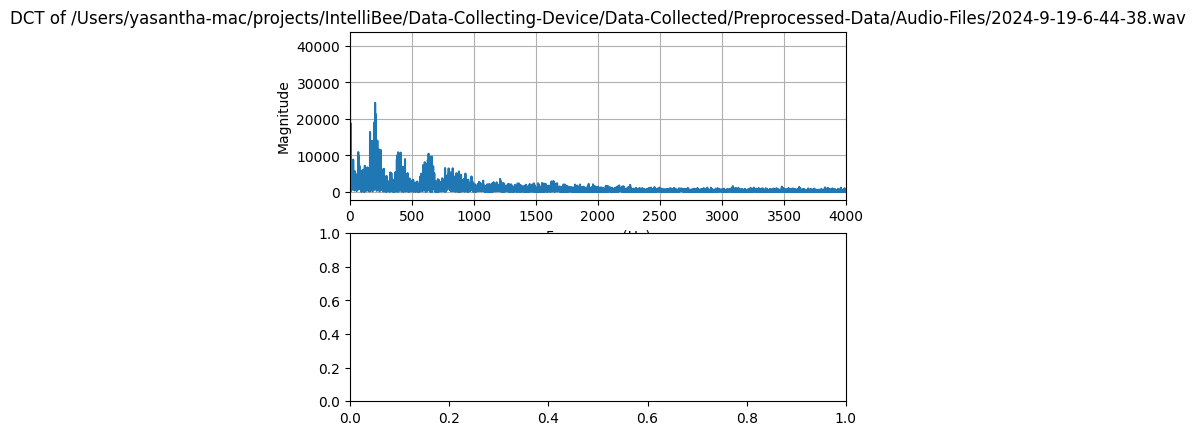

In [15]:
# Plot DCT
plt.subplot(2, 1, 1)
plt.plot(frequencies[:N//2], dct_magnitude[:N//2])
plt.title(f'DCT of {PREPROCESSED_DATA_PATH}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, sample_rate / 2)  # Plot up to Nyquist frequency
plt.grid()

# Plot LPC Spectrum
plt.subplot(2, 1, 2)
lpc_frequencies = np.fft.fftfreq(len(lpc_filter), 1/sample_rate)
plt.plot(lpc_frequencies[:N//2], lpc_spectrum[:N//2] * lpc_gain)  # Normalize by gain
plt.title(f'LPC Spectrum of {PREPROCESSED_DATA_PATH}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, sample_rate / 2)  # Plot up to Nyquist frequency
plt.grid()

plt.tight_layout()
plt.show()

In [26]:
import numpy as np

def goertzel(samples, target_freq, sampling_rate):
    """
    Goertzel Algorithm to detect the magnitude of a specific frequency in a signal.

    :param samples: List or NumPy array of audio samples.
    :param target_freq: Target frequency to detect (Hz).
    :param sampling_rate: Sampling rate of the audio signal (Hz).
    :return: Magnitude of the target frequency.
    """
    num_samples = len(samples)
    k = int(0.5 + (num_samples * target_freq) / sampling_rate)
    omega = (2.0 * np.pi * k) / num_samples
    sine = np.sin(omega)
    cosine = np.cos(omega)
    coeff = 2.0 * cosine

    q0, q1, q2 = 0.0, 0.0, 0.0

    # Process the samples
    for sample in samples:
        q0 = coeff * q1 - q2 + sample
        q2 = q1
        q1 = q0

    # Compute the magnitude
    real = q1 - q2 * cosine
    imag = q2 * sine
    magnitude = np.sqrt(real**2 + imag**2)

    return magnitude

In [32]:
import numpy as np
from scipy.signal import butter, filtfilt, hilbert

def amplitude_in_band(samples, sampling_rate, lowcut, highcut):
    """
    Extracts the amplitude of a signal in a given frequency range using a band-pass filter
    and the Hilbert Transform.
    
    Args:
        samples (array-like): Input signal.
        sampling_rate (float): Sampling rate of the signal in Hz.
        lowcut (float): Lower bound of the frequency range in Hz.
        highcut (float): Upper bound of the frequency range in Hz.
        
    Returns:
        float: The RMS amplitude in the specified frequency band.
    """
    # Ensure input is a NumPy array
    samples = np.asarray(samples, dtype=np.float32)
    
    # Nyquist frequency
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Check frequency validity
    if not (0 < low < 1 and 0 < high < 1):
        raise ValueError("Cutoff frequencies must be between 0 and Nyquist frequency.")
    
    # Design band-pass filter
    b, a = butter(4, [low, high], btype='band')
    filtered = filtfilt(b, a, samples)
    
    # Apply Hilbert Transform
    analytic_signal = hilbert(filtered)
    amplitude_envelope = np.abs(analytic_signal)  # Instantaneous amplitude
    
    # Calculate RMS amplitude
    rms_amplitude = np.sqrt(np.mean(amplitude_envelope**2))
    return rms_amplitude

In [ ]:
from scipy.signal import butter, filtfilt

data = np.array(data, dtype=np.float32)

def bandpass_filter(samples, sampling_rate, lowcut, highcut):
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered = filtfilt(b, a, samples)
    amplitude = np.sqrt(np.mean(filtered**2))  # RMS Amplitude
    return amplitude


amplitude = bandpass_filter(data,8000,225,285)

print(f'Amplitude: {amplitude:.4f}')


Amplitude: 496.3985


In [65]:
os.listdir(os.path.join(PARENT_PATH, 'Data-Collected','Raw-Data','Sample-02'))
file_paths = list()
for os_path in os.listdir(os.path.join(PARENT_PATH, 'Data-Collected','Raw-Data','Sample-02')):
    file_paths.append(os.path.join(PARENT_PATH, 'Data-Collected','Raw-Data','Sample-02',os_path))

file_paths.remove(os.path.join(PARENT_PATH, 'Data-Collected','Raw-Data','Sample-02','data.csv'))
frequencies = list()
amplitudes = list()

file_paths = file_paths[:181]

print(len(file_paths))

181


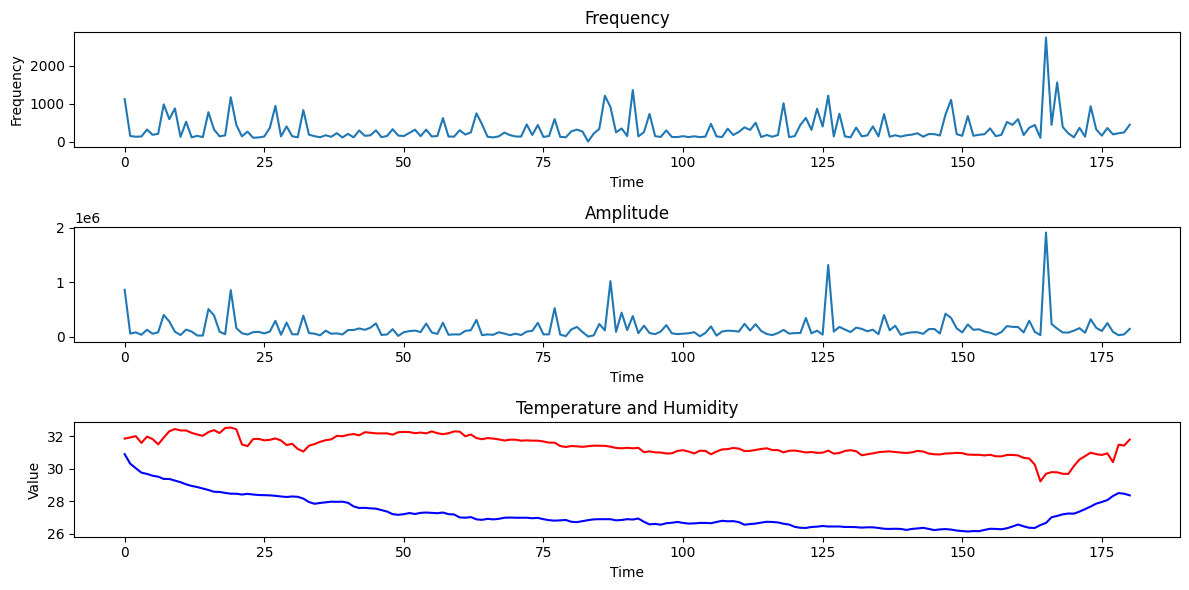

In [66]:


for file_path in file_paths:
    with open(file_path, 'r') as file:
        data = file.read()
        data = data.split('\n')[1].strip(",").split(',')
        data = data[:8000]
        numpy_data = np.array(data, dtype=np.int32)
        amplitude_goertzel = goertzel(numpy_data, 250, 8000)
        amplitude = amplitude_in_band(numpy_data,8000,225,285)
        amplitudes.append(amplitude_goertzel)
        frequencies.append(amplitude)

import pandas as pd

# plot both amplitudes and frequencies in two subplots and temperature and humidity in another subplot

 
csv_file = os.path.join(PARENT_PATH, 'Data-Collected','Preprocessed-Data','CSV-Files','sample-02.csv')
df = pd.read_csv(csv_file)
df = df[["Temp In","Temp Out","Hum In","Hum Out"]]
df.head()

df["Frequency"] = frequencies
df["Amplitude"] = amplitudes
df.head()


plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(df["Frequency"])
plt.title("Frequency")
plt.xlabel("Time")
plt.ylabel("Frequency")

plt.subplot(3, 1, 2)
plt.plot(df["Amplitude"])
plt.title("Amplitude")
plt.xlabel("Time")

#plot temperature and humidity

plt.subplot(3, 1, 3)
plt.plot(df["Temp In"], label="Temp In", color='red')
plt.plot(df["Temp Out"], label="Temp Out", color='blue')
plt.title("Temperature and Humidity")
plt.xlabel("Time")
plt.ylabel("Value")
plt.tight_layout()
plt.show()
